In [1]:
import numpy as np
import gymnasium as gym
import torch 
import torch.nn.functional as F
import collections
import random
import copy
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

After adopting the replay buffer, there is still a problem for calculating the gradient of the loss function. If we update and utilize the policy network at the same time, the training process will be unstable. Therefore, we need to use a target network to calculate the target value. The target network is a copy of the main network, and it is updated every specific step size. The target network, with parameters $w_T$ is used to calculate the TD target. The main network, with parameters $w$ is used to calculate the current value. Hence, the training process is as follows:

\begin{equation}
w \gets w - \alpha_t \left(r_{t+1}+\gamma \max_{a^{\prime} \in \mathcal{A}(s_{t+1})} \hat{q}\left(s_{t+1}, a^{\prime}, w_{T}\right)-\hat{q}(s_t, a_t, w)\right) \nabla_{w} \hat{q}(s_t, a_t, w)
\end{equation}
where \{$s_t$, $a_t$, $r_t$, $s_{t+1}$\} is uniformly sampled from the experience replay buffer.

In [2]:
class DQN_Agent():
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    
    def __init__(self,
                 Q_func:torch.nn.Module,
                 action_dim:int,
                 optimizer:torch.optim.Optimizer,
                 replay_buffer:collections.deque,
                 replay_start_size:int,
                 batch_size:int,
                 replay_frequent:int,
                 target_sync_frequent:int, # The frequency of synchronizing the parameters of the two Q networks
                 epsilon:float = 0.1, # Initial epsilon
                 mini_epsilon:float = 0.01, # Minimum epsilon
                 explore_decay_rate:float = 0.0001, # Decay rate of epsilon
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        
        self.device = device
        self.action_dim = action_dim
        
        self.exp_counter = 0
        
        self.replay_buffer = replay_buffer
        self.replay_start_size = replay_start_size
        self.batch_size = batch_size
        self.replay_frequent = replay_frequent
        
        self.target_update_frequent = target_sync_frequent
        
        """Two Q functions (mian_Q and target_Q) are used to stabilize the training process. 
            Since they share the same network structure, we can use copy.deepcopy to copy the main_Q to target_Q for initialization."""
        self.main_Q_func = Q_func
        self.target_Q_func = copy.deepcopy(Q_func)
        
        self.criteria = torch.nn.MSELoss()
        self.optimizer = optimizer
        
        self.epsilon = epsilon
        self.mini_epsilon = mini_epsilon
        self.gamma = gamma
        self.explore_decay_rate = explore_decay_rate
        
    pass

    def get_target_action(self,obs:np.ndarray) -> int:
        obs = torch.tensor(obs,dtype=torch.float32,device=self.device)
        Q_list = self.target_Q_func(obs)
        action = torch.argmax(Q_list).item()
        return action

    def get_behavior_action(self,obs:np.ndarray) -> int:
        """Here, a simple epsilon decay is used to balance the exploration and exploitation.
            The epsilon is decayed from epsilon_init to mini_epsilon."""
        self.epsilon = max(self.mini_epsilon,self.epsilon-self.explore_decay_rate)
        
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            action = self.get_target_action(obs)
            
        return action
    
    """Here, we defined a function to synchronize the parameters of the main_Q and target_Q."""
    def sync_target_Q_func(self) -> None:
        for target_params, main_params in zip(self.target_Q_func.parameters(), self.main_Q_func.parameters()):
            target_params.data.copy_(main_params.data)
            
    
    def batch_Q_approximation(self,
                              batch_obs:np.ndarray,
                              batch_action:np.ndarray,
                              batch_reward:np.ndarray,
                              batch_next_obs:np.ndarray,
                              batch_done:np.ndarray) -> None:
        
        batch_current_Q = torch.gather(self.main_Q_func(batch_obs),1,batch_action).squeeze(1)
        batch_TD_target = batch_reward + (1-batch_done) * self.gamma * self.target_Q_func(batch_next_obs).max(1)[0]
        loss = self.criteria(batch_current_Q,batch_TD_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
            
    def Q_approximation(self,
                        obs:np.ndarray,
                        action:int,
                        reward:float,
                        next_obs:np.ndarray,
                        done:bool) -> None:
        
        self.exp_counter += 1
        self.replay_buffer.append((obs,action,reward,next_obs,done))

        if len(self.replay_buffer) > self.replay_start_size and self.exp_counter%self.replay_frequent == 0:
            self.batch_Q_approximation(*self.replay_buffer.sample(self.batch_size))
        
        # Synchronize the parameters of the two Q networks every target_update_frequent steps
        if self.exp_counter%self.target_update_frequent == 0:
            self.sync_target_Q_func()

In [3]:
class Q_Network(torch.nn.Module):
    """You can define your own network structure here."""
    def __init__(self,obs_dim:int,action_dim) -> None:
        super(Q_Network,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
            
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [4]:
class ReplayBuffer():
    def __init__(self,capacity:int,device:torch.device = torch.device("cpu")) -> None:
        self.device = device
        self.buffer = collections.deque(maxlen=capacity)
        
    def append(self,exp_data:tuple) -> None:
        self.buffer.append(exp_data)
        
    def sample(self,batch_size:int) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor,torch.Tensor,torch.Tensor]:
        mini_batch = random.sample(self.buffer,batch_size)
        obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = zip(*mini_batch)
        
        obs_batch = np.array(obs_batch)
        next_obs_batch = np.array(next_obs_batch)
        
        obs_batch = torch.tensor(obs_batch,dtype=torch.float32,device=self.device)
        
        action_batch = torch.tensor(action_batch,dtype=torch.int64,device=self.device) 
        action_batch = action_batch.unsqueeze(1)
        
        reward_batch = torch.tensor(reward_batch,dtype=torch.float32,device=self.device)
        next_obs_batch = torch.tensor(next_obs_batch,dtype=torch.float32,device=self.device)
        done_batch = torch.tensor(done_batch,dtype=torch.int64,device=self.device)
          
        return obs_batch, action_batch, reward_batch, next_obs_batch, done_batch
    
    def __len__(self) -> int:
        return len(self.buffer)

In [5]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 lr:float = 0.001,
                 gamma:float = 0.9,
                 epsilon:float = 0.1,
                 mini_epsilon:float = 0.01,
                 explore_decay_rate:float = 0.0001,
                 buffer_capacity:int = 2000,
                 replay_start_size:int = 200,
                 replay_frequent:int = 4,
                 target_sync_frequent:int = 200,
                 batch_size:int = 32,
                 seed = 0) -> None:
        
        self.seed = seed
        random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
        
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space)
        action_dim = env.action_space.n
        self.buffer = ReplayBuffer(capacity=buffer_capacity,device=self.device)
        Q_func = Q_Network(obs_dim,action_dim)
        Q_func.to(self.device)
        optimizer = torch.optim.Adam(Q_func.parameters(),lr=lr)
        self.agent = DQN_Agent(Q_func = Q_func,
                               action_dim = action_dim,
                               optimizer = optimizer,
                               replay_buffer = self.buffer,
                               replay_start_size = replay_start_size,
                               batch_size = batch_size,
                               replay_frequent = replay_frequent,
                               target_sync_frequent = target_sync_frequent,
                               epsilon = epsilon,
                               mini_epsilon = mini_epsilon,
                               explore_decay_rate = explore_decay_rate,
                               gamma = gamma,
                               device = self.device)
        
        self.episode_total_rewards = np.zeros(episode_num)
        self.index_episode = 0 
        
        
    def train_episode(self,is_render:bool=False) -> float:
        total_reward = 0 
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action = self.agent.get_behavior_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            total_reward += reward 
            self.agent.Q_approximation(obs,action,reward,next_obs,done)
            obs = next_obs
            if is_render:
                self.env.render()
                                
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
            
        return total_reward       

    def test_episode(self) -> float:
        total_reward = 0 
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action = self.agent.get_target_action(obs) 
            next_obs, reward, terminated, truncated, _= self.env.step(action) 
            done = terminated or truncated
            obs = next_obs
            total_reward += reward
            self.env.render()
            if done: break
            
        return total_reward
            
            
    def train(self) -> None:        
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%100 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
            
            # if e%100 == 0: 
            #     test_reward = self.test_episode()
            #     print('Test Total Reward = %.2f'%(test_reward))
            
    def plotting(self,smoothing_window:int = 100) -> None:    
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()

c:\Users\gemin\miniconda3\envs\pytorch\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Episode 0: Total Reward = 11.00
Episode 100: Total Reward = 11.00
Episode 200: Total Reward = 8.00
Episode 300: Total Reward = 14.00
Episode 400: Total Reward = 33.00
Episode 500: Total Reward = 47.00
Episode 600: Total Reward = 59.00
Episode 700: Total Reward = 103.00
Episode 800: Total Reward = 200.00
Episode 900: Total Reward = 176.00


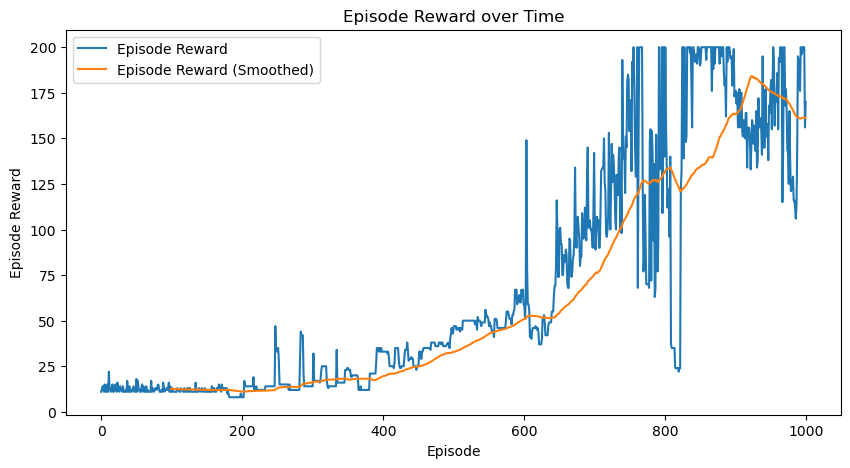

In [6]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        lr = 0.001,
                        gamma = 0.9,
                        epsilon = 0.3,
                        target_sync_frequent = 200,
                        mini_epsilon = 0.01,
                        explore_decay_rate = 0.0001
                        )
    Manger.train()
    Manger.plotting()